In [1]:
import pydicom
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize

> pydicom
https://pyscience.wordpress.com/2014/09/08/dicom-in-python-importing-medical-image-data-into-numpy-with-pydicom-and-vtk/


> Get Dicom File List

In [2]:
from os import walk
PathDicom = 'MRCT/DICOM/CT L1-L5 (1mm)/S3010/'
lstFilesDCM = []
# get all file name in a directory
for (dirpath, dirnames, filenames) in walk(PathDicom):
    lstFilesDCM.extend(filenames)
    break
for i in range(len(lstFilesDCM)):
    lstFilesDCM[i] = PathDicom + lstFilesDCM[i]
#print(lstFilesDCM)

> Get Dicom Ref

In [3]:
# Get ref file
RefDs = pydicom.read_file(lstFilesDCM[0])
# Load dimensions based on the number of rows, columns, and slices (along the Z axis)
ConstPixelDims = (int(RefDs.Rows), int(RefDs.Columns), len(lstFilesDCM))
print (ConstPixelDims)
# Load spacing values (in mm)
ConstPixelSpacing = (float(RefDs.PixelSpacing[0]), float(RefDs.PixelSpacing[1]), float(RefDs.SliceThickness))
print (ConstPixelSpacing)

(512, 512, 341)
(0.4375, 0.4375, 1.0)


> Dicom -> Array

In [4]:
# The array is sized based on 'ConstPixelDims'
ArrayDicom = np.zeros(ConstPixelDims, dtype=RefDs.pixel_array.dtype)

# loop through all the DICOM files
for filenameDCM in lstFilesDCM:
    # read the file
    ds = pydicom.read_file(filenameDCM)
    # store the raw image data
    ArrayDicom[:, :, lstFilesDCM.index(filenameDCM)] = ds.pixel_array  

[[ 913  852  903 ... 1072  943 1101]
 [ 941  884  838 ... 1000  994 1079]
 [ 987  956  873 ... 1006 1124 1067]
 ...
 [  60   47  103 ...   11    3   84]
 [  45  139  151 ...   61    0    0]
 [ 163  143   37 ...  122  130  116]] uint16
range:  2648  ( 0 ~ 2648 )
[[ 93  86  92 ... 109  96 112]
 [ 95  90  85 ... 102 101 110]
 [100  97  89 ... 102 114 108]
 ...
 [  6   4  10 ...   1   0   8]
 [  4  14  15 ...   6   0   0]
 [ 16  14   3 ...  12  13  11]] uint8


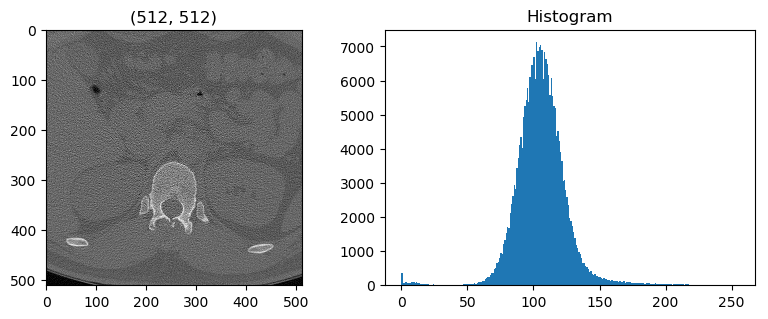

In [9]:
num = 100
DicomImg = ArrayDicom[:, :, num]

print (DicomImg, np.dtype(DicomImg[0][0]))
print ('range: ',np.ptp(DicomImg),' (' , np.min(DicomImg),'~' , np.max(DicomImg), ')')

plt.figure(num=None, figsize=(8, 6), dpi=100, facecolor='w', edgecolor='k')

# Normalised [0,255]
DicomImg_norm = (DicomImg - 0) / 2500 * 255
plt.subplot(221), plt.title(DicomImg.shape), plt.imshow(DicomImg_norm, cmap='gray')

# uint16 uint8
DicomImg_norm = DicomImg_norm.astype(np.uint8)
print (DicomImg_norm, np.dtype(DicomImg_norm[0][0]))
plt.subplot(222), plt.title('Histogram'), plt.hist(DicomImg_norm.ravel(),255,[0,255])

plt.tight_layout()
plt.show()

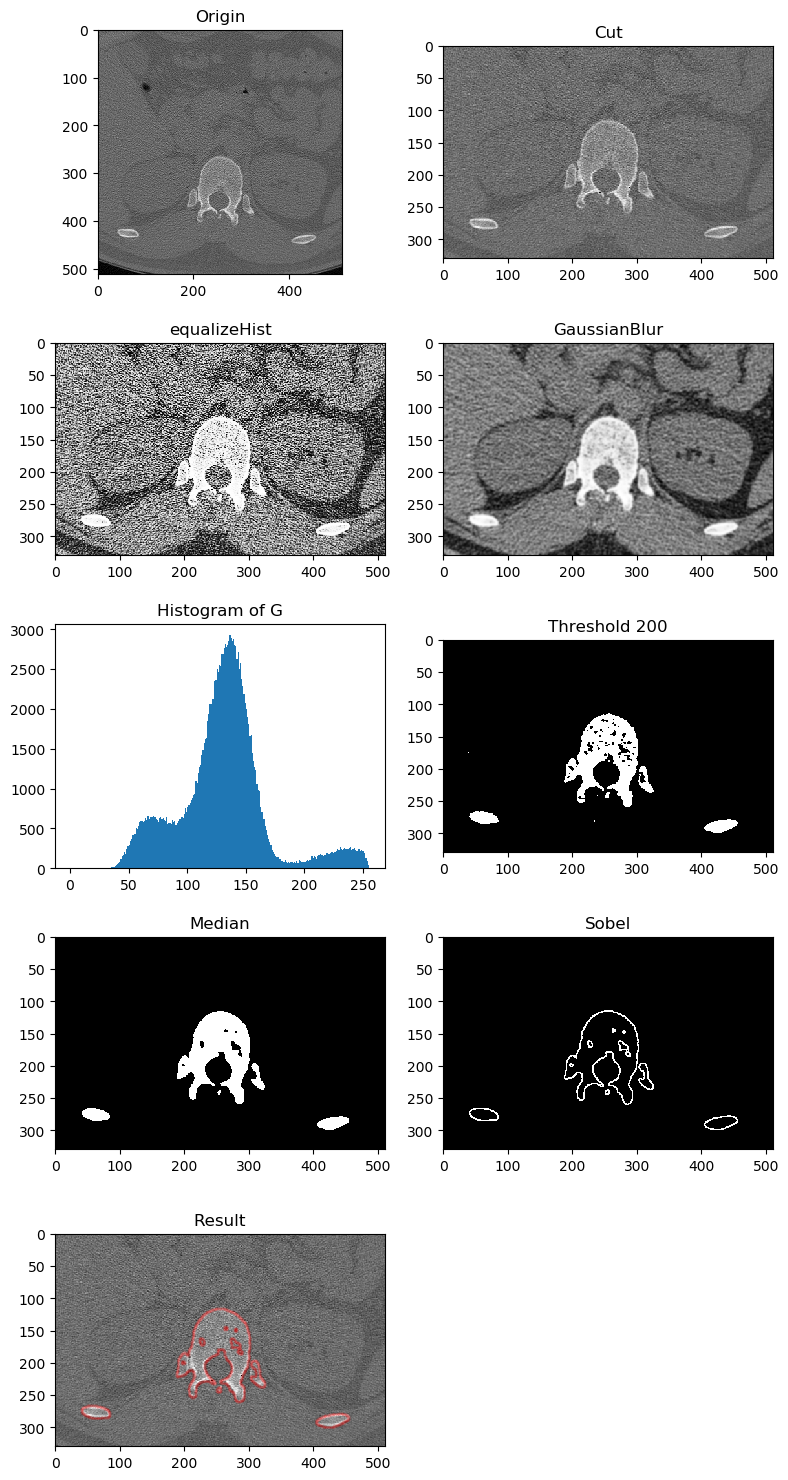

In [43]:
plt.figure(num=None, figsize=(8, 15), dpi=100, facecolor='w', edgecolor='k')

# Origin
plt.subplot(521), plt.title('Origin'), plt.imshow(DicomImg, cmap='gray')

# Cut
DicomImgCut = DicomImg_norm[150:480, 0:512]
plt.subplot(522), plt.title('Cut'), plt.imshow(DicomImgCut, cmap='gray')

# Histograms Equalization
DicomImgCut_HE = cv2.equalizeHist(DicomImgCut)
plt.subplot(523), plt.title('equalizeHist'), plt.imshow(DicomImgCut_HE, cmap='gray')

# GaussianBlur
DicomImgCut_G = cv2.GaussianBlur(DicomImgCut_HE,(7,7),0,0)
plt.subplot(524), plt.title('GaussianBlur'), plt.imshow(DicomImgCut_G, cmap='gray')

# Histogram
plt.subplot(525), plt.title('Histogram of G'), plt.hist(DicomImgCut_G.ravel(),256,[0,256])

# Threshold
Threshold = 200
DicomImgCut_T = (DicomImgCut_G > Threshold) * 255
DicomImgCut_T = DicomImgCut_T.astype(np.uint8)
plt.subplot(526), plt.title('Threshold '+str(Threshold)), plt.imshow(DicomImgCut_T, cmap='gray')

# MedianBlur
DicomImgCut_MED = cv2.medianBlur(DicomImgCut_T, 7)
plt.subplot(527), plt.title('Median'), plt.imshow(DicomImgCut_MED, cmap='gray')

# Sobel
sobelx = cv2.Sobel(DicomImgCut_MED,cv2.CV_64F,1,0,ksize=3)  # x
sobely = cv2.Sobel(DicomImgCut_MED,cv2.CV_64F,0,1,ksize=3)  # y
absX = cv2.convertScaleAbs(sobelx) 
absY = cv2.convertScaleAbs(sobely)
DicomImgCut_S = cv2.addWeighted(absX,1,absY,1,0)
plt.subplot(528), plt.title('Sobel'), plt.imshow(DicomImgCut_S, cmap='gray')

# Result
x,y = np.argwhere(DicomImgCut_S == 255).T
plt.subplot(529), plt.title('Result'), plt.imshow(DicomImgCut, cmap='gray')
plt.scatter(y, x, marker='.', c='r', s=0.01)

plt.tight_layout()
plt.show()

In [44]:
def CT_IP(DicomImg, num_list):
    for num in num_list:
        plt.figure(num=None, figsize=(8, 15), dpi=100, facecolor='w', edgecolor='k')
        DicomImg = ArrayDicom[:, :, num]
        # Normalised [0,255]
        DicomImg_norm = (DicomImg - 0) / 2500 * 255
        # uint16 uint8
        DicomImg_norm = DicomImg_norm.astype(np.uint8)
        # Cut
        DicomImgCut = DicomImg_norm[150:480, 0:512]
        plt.subplot(121), plt.title(num), plt.imshow(DicomImgCut, cmap='gray')
        # Histograms Equalization
        DicomImgCut_HE = cv2.equalizeHist(DicomImgCut)
        # GaussianBlur
        DicomImgCut_G = cv2.GaussianBlur(DicomImgCut_HE,(7,7),0,0)
        # Threshold
        Threshold = 200
        DicomImgCut_T = (DicomImgCut_G > Threshold) * 255
        DicomImgCut_T = DicomImgCut_T.astype(np.uint8)
        # MedianBlur
        DicomImgCut_MED = cv2.medianBlur(DicomImgCut_T, 7)
        # Sobel
        sobelx = cv2.Sobel(DicomImgCut_MED,cv2.CV_64F,1,0,ksize=3)  # x
        sobely = cv2.Sobel(DicomImgCut_MED,cv2.CV_64F,0,1,ksize=3)  # y
        absX = cv2.convertScaleAbs(sobelx) 
        absY = cv2.convertScaleAbs(sobely)
        DicomImgCut_S = cv2.addWeighted(absX,1,absY,1,0)
        # Result
        x,y = np.argwhere(DicomImgCut_S == 255).T
        plt.subplot(122), plt.title(str(num)), plt.imshow(DicomImgCut, cmap='gray')
        plt.scatter(y, x, marker='.', c='r', s=0.01)
        plt.show()

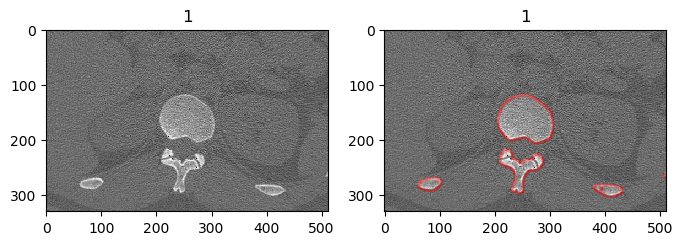

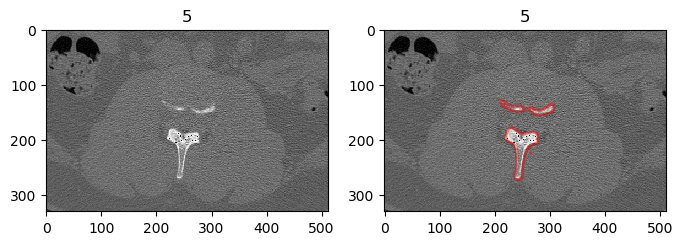

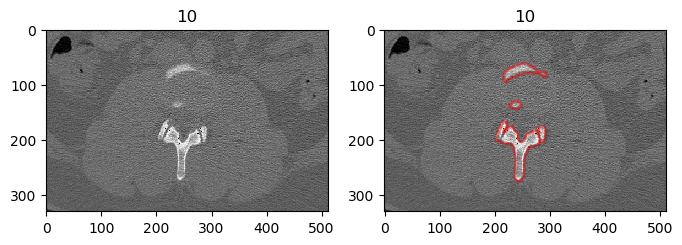

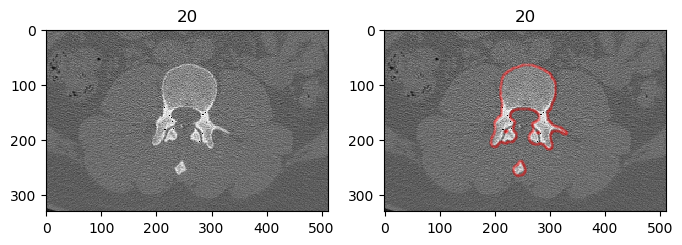

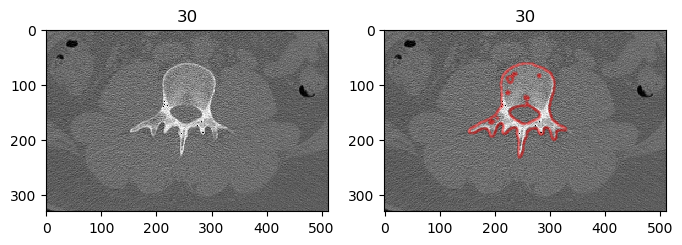

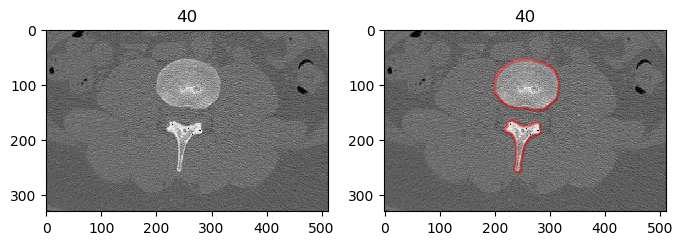

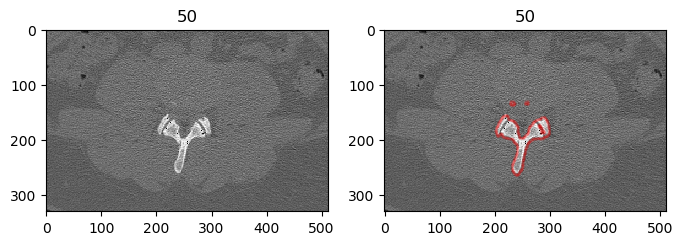

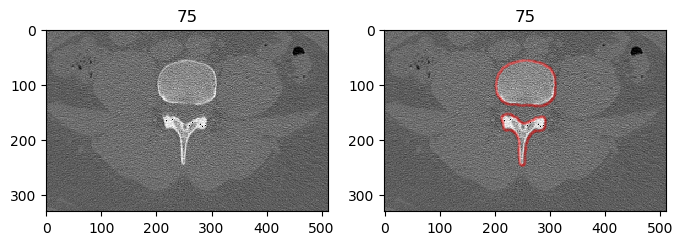

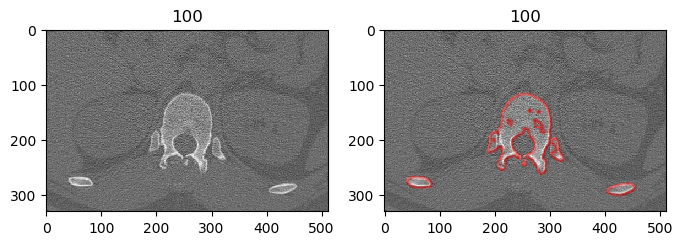

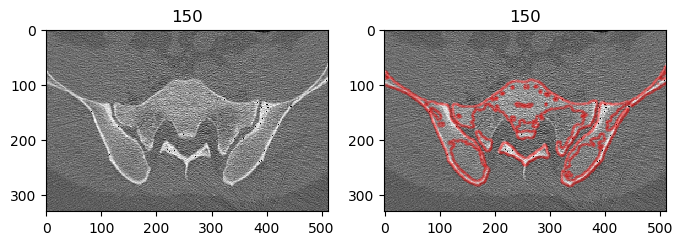

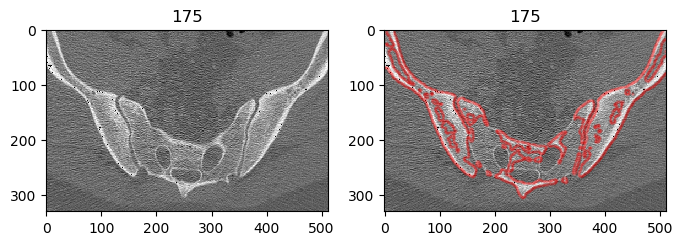

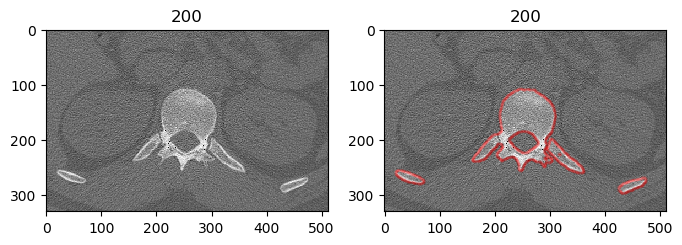

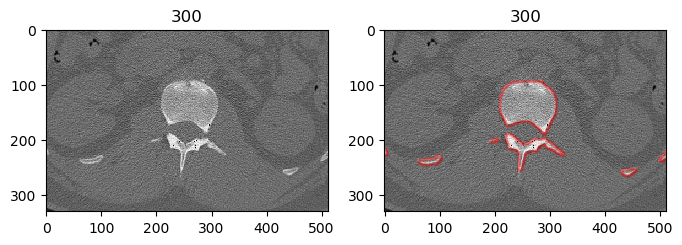

In [45]:
num_list = [1,5,10,20,30,40,50,75,100,150,175,200,300]
CT_IP(DicomImg, num_list)